In [35]:
import pandas as pd
import json
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Preprocess Data
Import data. Remove redundant columns. Split categories into list. Create a counter of all categories, and assign each company to the most popular one. For example, [Gastropubs, Food, Beer Gardens, Restaurant] -> restaurant. Map unique categories to integers.

In [2]:
df = pd.read_json("C:\Datasets\yelp\yelp_academic_dataset_business.json", lines=True)
df = df.drop(columns = ["business_id", "address", "city", "state", "postal_code", "latitude", "longitude", "stars", "review_count", "is_open", "attributes","hours"])
df.dropna(inplace = True)
df["categories"] = df["categories"].str.split(",")
df["name"] = df["name"].str.lower()

In [3]:
df.head()

,name,categories
0,oskar blues taproom,"[Gastropubs, Food, Beer Gardens, Restaurant..."
1,flying elephants at pdx,"[Salad, Soup, Sandwiches, Delis, Restauran..."
2,the reclaimory,"[Antiques, Fashion, Used, Vintage & Consign..."
3,great clips,"[Beauty & Spas, Hair Salons]"
4,crossfit terminus,"[Gyms, Active Life, Interval Training Gyms, ..."


In [4]:
cat_counter = Counter()
for i in range(len(df)):
    cats = df.iloc[i, 1]
    for cat in cats:
        cat_counter[cat.lower().strip()] += 1

def cat_selector(x, cat_counter):
    final_word = ""
    largest_word = 0
    for word in x:
        word = word.lower().strip()
        if cat_counter[word] > largest_word:
            largest_word = cat_counter[word]
            final_word = word
    return final_word

df["cat1"] = df.apply(lambda x: cat_selector(x["categories"], cat_counter), axis = 1)

In [5]:
df.head()

,name,categories,cat1
0,oskar blues taproom,"[Gastropubs, Food, Beer Gardens, Restaurant...",restaurants
1,flying elephants at pdx,"[Salad, Soup, Sandwiches, Delis, Restauran...",restaurants
2,the reclaimory,"[Antiques, Fashion, Used, Vintage & Consign...",shopping
3,great clips,"[Beauty & Spas, Hair Salons]",beauty & spas
4,crossfit terminus,"[Gyms, Active Life, Interval Training Gyms, ...",active life


In [6]:
cat_to_idx = dict(zip(df["cat1"].unique(), range(len(df["cat1"].unique()))))
df["cat1_idx"] = df["cat1"].map(cat_to_idx)
df.head()


,name,categories,cat1,cat1_idx
0,oskar blues taproom,"[Gastropubs, Food, Beer Gardens, Restaurant...",restaurants,0
1,flying elephants at pdx,"[Salad, Soup, Sandwiches, Delis, Restauran...",restaurants,0
2,the reclaimory,"[Antiques, Fashion, Used, Vintage & Consign...",shopping,1
3,great clips,"[Beauty & Spas, Hair Salons]",beauty & spas,2
4,crossfit terminus,"[Gyms, Active Life, Interval Training Gyms, ...",active life,3


# Prepare Data
Tokenize company names. Turn tokens to integers. Pad sequences of integers with 0s (max of 10). One hot encode categories. Create a dictionary **idx2classes** that maps class integer to class name. Create dictionary **idx2word** that maps indices to words, and dictionary **word2idx** that maps words to indices.

In [8]:
max_len = 10

In [9]:
text_sequences = df["name"].to_list()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
text_sequences = tokenizer.texts_to_sequences(text_sequences)
text_sequences = pad_sequences(text_sequences, maxlen = 10, padding='post', truncating='post')

num_records = len(text_sequences)
max_seqlen = len(text_sequences[0])
print(f'Numbers records: {len(text_sequences)}, Max_length: {len(text_sequences[0])}')

Numbers records: 160470, Max_length: 10


In [10]:
num_classes = len(df["cat1"].unique())
cat_labels = to_categorical(df["cat1_idx"].to_list(), num_classes=num_classes)
print(f'Numbers records: {len(text_sequences)}')

Numbers records: 160470


In [57]:
idx2classes = dict(zip(range(len(df["cat1"].unique())),df["cat1"].unique()))
print(idx2classes)

{0: 'restaurants', 1: 'shopping', 2: 'beauty & spas', 3: 'active life', 4: 'health & medical', 5: 'food', 6: 'automotive', 7: 'event planning & services', 8: 'education', 9: 'local services', 10: 'home services', 11: 'nightlife', 12: 'pets', 13: 'hotels & travel', 14: 'financial services', 15: 'arts & entertainment', 16: 'religious organizations', 17: 'public services & government', 18: 'professional services', 19: 'mass media', 20: 'local flavor'}


In [11]:
word2idx = tokenizer.word_index
idx2word = {v:k for k,v in word2idx.items()}
word2idx["PAD"] = 0
idx2word[0] = "PAD"
vocab_size = len(word2idx)
print(f'Vocab size: {vocab_size}')

Vocab size: 47699


# Build Embedding Matrix
Download list of models in gensim. Download model. Create embedding matrix given vocabulary. 

In [14]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [15]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

In [16]:
def build_embedding_matrix(sequences, word2idx, embedding_dim, embedding_file, word_vectors):
    if os.path.exists(embedding_file):
        E = np.load(embedding_file)
    else:
        vocab_size = len(word2idx)
        E = np.zeros((vocab_size, embedding_dim))
        for word, idx in word2idx.items():
            try:
                E[idx] = word_vectors[word]
            except KeyError:
                pass
        np.save(embedding_file, E)
    return E

In [17]:
embedding_dim = 300
embedding_numpy_file = os.path.join("data", "embeddings.npy")
E = build_embedding_matrix(text_sequences, word2idx, 300, embedding_numpy_file, glove_vectors)
print(f'Embedding matrix shape: {E.shape}')

Embedding matrix shape: (47699, 300)


# Split Dataset
Split dataset into train / test dataset. Calculate class weights to ensure unbiased training.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(text_sequences, cat_labels, test_size=0.2, random_state=7)
print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (128376, 10)
X_test.shape: (32094, 10)
y_train.shape: (128376, 21)
y_test.shape: (32094, 21)


In [19]:
class_weights = np.reciprocal(y_train.sum(axis=0)/sum(y_train.sum(axis=0)))
class_weights = dict(zip(range(num_classes), class_weights))
print(class_weights)

{0: 3.1640747, 1: 6.902678, 2: 11.232478, 3: 31.760515, 4: 16.326593, 5: 12.234442, 6: 19.351221, 7: 38.47048, 8: 245.93105, 9: 28.578808, 10: 11.753891, 11: 63.61546, 12: 51.57734, 13: 88.84152, 14: 135.27502, 15: 169.80952, 16: 729.4091, 17: 282.14505, 18: 136.8614, 19: 1078.7899, 20: 1018.8571}


# ANN Model

In [89]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [90]:
embedding_size = 300

In [91]:
model = Sequential()
model.add(Embedding(vocab_size, 300, input_length=10, weights=[E], trainable = True))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(21, activation='softmax'))

In [92]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [93]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 300)           14309700  
_________________________________________________________________
flatten_1 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                192064    
_________________________________________________________________
dense_5 (Dense)              (None, 21)                1365      
Total params: 14,503,129
Trainable params: 14,503,129
Non-trainable params: 0
_________________________________________________________________


In [94]:
model_checkpoint = ModelCheckpoint("ANN.h5", save_best_only=True)

In [131]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 64, epochs = 5, callbacks = [model_checkpoint], class_weight=class_weights)

Epoch 1/5
2006/2006 [==============================] - 277s 138ms/step - loss: 6.7980 - accuracy: 0.8571 - val_loss: 0.9844 - val_accuracy: 0.7319
Epoch 2/5
2006/2006 [==============================] - 312s 156ms/step - loss: 4.3833 - accuracy: 0.8927 - val_loss: 1.0114 - val_accuracy: 0.7486
Epoch 3/5
2006/2006 [==============================] - 308s 154ms/step - loss: 3.3249 - accuracy: 0.9147 - val_loss: 1.0782 - val_accuracy: 0.7377
Epoch 4/5
2006/2006 [==============================] - 316s 158ms/step - loss: 2.7662 - accuracy: 0.9268 - val_loss: 1.1185 - val_accuracy: 0.7391
Epoch 5/5
2006/2006 [==============================] - 307s 153ms/step - loss: 2.3984 - accuracy: 0.9365 - val_loss: 1.2436 - val_accuracy: 0.7348


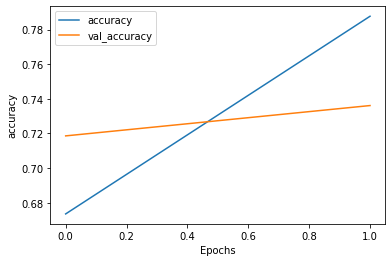

In [97]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(["accuracy", "val_accuracy"])
plt.show()

In [116]:
text = ["food hut", "funeral services", "rat killer", "sandwich shop", "sloppy joes"]
sequences = tokenizer.texts_to_sequences(text)
sequences = pad_sequences(sequences, maxlen = 10, padding='post', truncating='post')
result = model.predict_on_batch(sequences)
np.argmax(result, axis=-1)

array([5, 9, 1, 0, 0], dtype=int64)

In [125]:
def get_predictions(text, idx2classes):
    sequence = tokenizer.texts_to_sequences([text.lower().strip()])
    sequence = pad_sequences(sequence, maxlen = 10, padding='post', truncating='post')
    prediction = model.predict(sequence)
    return idx2classes[np.argmax(prediction)]
    

In [130]:
get_predictions("ronnie scotts", idx2classes)

'public services & government'

# RNN Model

In [27]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM

In [28]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 300, input_length=10, weights=[E], trainable = True))
model2.add(Bidirectional(LSTM(max_len)))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(21, activation='sigmoid'))

In [31]:
model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [32]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 300)           14309700  
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                24880     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                1365      
Total params: 14,337,289
Trainable params: 14,337,289
Non-trainable params: 0
_________________________________________________________________


In [33]:
model_checkpoint = ModelCheckpoint("RNN.h5", save_best_only=True)

In [34]:
history2 = model2.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 64, epochs = 10, callbacks = [model_checkpoint], class_weight=class_weights)

Epoch 1/10
2006/2006 [==============================] - 244s 122ms/step - loss: 31.3248 - accuracy: 0.5784 - val_loss: 1.0879 - val_accuracy: 0.7035
Epoch 2/10
2006/2006 [==============================] - 262s 131ms/step - loss: 15.7122 - accuracy: 0.7542 - val_loss: 1.0203 - val_accuracy: 0.7159
Epoch 3/10
2006/2006 [==============================] - 270s 134ms/step - loss: 9.8356 - accuracy: 0.8214 - val_loss: 1.0251 - val_accuracy: 0.7257
Epoch 4/10
2006/2006 [==============================] - 252s 126ms/step - loss: 6.8541 - accuracy: 0.8576 - val_loss: 0.9715 - val_accuracy: 0.7404
Epoch 5/10
2006/2006 [==============================] - 248s 124ms/step - loss: 5.3365 - accuracy: 0.8781 - val_loss: 1.0296 - val_accuracy: 0.7330
Epoch 6/10
2006/2006 [==============================] - 266s 133ms/step - loss: 4.3571 - accuracy: 0.8926 - val_loss: 1.0220 - val_accuracy: 0.7436
Epoch 7/10
2006/2006 [==============================] - 269s 134ms/step - loss: 3.7900 - accuracy: 0.9015 - va

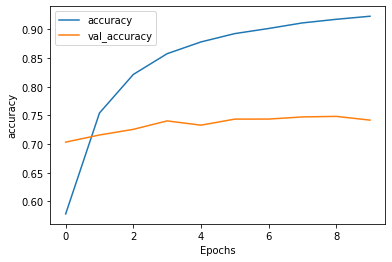

In [37]:
plt.plot(history2.history["accuracy"])
plt.plot(history2.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(["accuracy", "val_accuracy"])
plt.show()